In [8]:
from itertools import product, islice
from typing import Dict, List, Any, Tuple, Callable
import os
import pickle
from timeit import default_timer as timer
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial import distance

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator    

In [9]:
def get_datasets_hankel_matrix(io_data_list: List[IODataWith_l], lag: int, L: int) -> Tuple[np.matrix, np.matrix]:
    """Return tuple of [U_p; U_f; \tilde{Y}_p] and [\tilde{Y}_f]"""
    p = io_data_list[0]._output_data[0].shape[0]
    m = io_data_list[0]._input_data[0].shape[0]
    H_uy_noised: np.matrix = np.matrix(np.zeros(( p*lag+m*(L+lag),0 )))
    H_future_noised: np.matrix = np.matrix(np.zeros(( p*L,0 )))
    for io_data in io_data_list:
        if io_data.length >= L+lag: # only use data with enough length
            io_data.update_depth(L+lag)
            H_uy_noised_single = np.vstack( (io_data.H_input, io_data.H_output_noised_part((0, lag)),) )
            H_uy_noised = np.hstack(( H_uy_noised, H_uy_noised_single ))
            H_future_noised = np.hstack(( H_future_noised, io_data.H_output_noised_part((lag, lag+L)) ))
    return H_uy_noised, H_future_noised

def weighting_x_in_datasets(W_xi: np.matrix, f: Callable[[float], float], io_data_list: List[IODataWith_l], lag: int, L: int, x: np.ndarray)-> float:
    """Return the sum of f(||x-y||^2_{W_xi}) for all y in datasets"""
    p = io_data_list[0]._output_data[0].shape[0]
    m = io_data_list[0]._input_data[0].shape[0]
    H_uy_noised, H_future_noised = get_datasets_hankel_matrix(io_data_list, lag, L)
    delta_H_xi = np.vstack(( H_uy_noised[:m*lag,:], H_uy_noised[-p*lag:,:] )) - np.matrix(x).T
    width_H = delta_H_xi.shape[1]
    weight_list = np.zeros((width_H,))
    for i in range(width_H):
        weight_list[i] = f((delta_H_xi[:,i].T @ W_xi @ delta_H_xi[:,i])[0,0])
    return np.min([1.0, np.sum(weight_list)])

def monte_carlo_integrate(integrand, sampler, measure=1.0, n=100):
    # Sum elements and elements squared
    total = 0.0
    total_sq = 0.0
    for x in islice(sampler, n):
        f = integrand(x)
        total += f
        total_sq += (f**2)
    # Return answer
    sample_mean = total/n
    sample_var = (total_sq - (total**2)/n)/(n-1.0)
    return (measure*sample_mean, measure*math.sqrt(sample_var/n))

In [10]:
with open(os.path.join(os.getcwd(), 'datasets', '09-19_14_11-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl'), 'rb') as read_file:
    io_data_list_1: List[IODataWith_l] = pickle.load(read_file)[0]
with open(os.path.join(os.getcwd(), 'datasets', '09-19_14_14-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl'), 'rb') as read_file:
    io_data_list_2: List[IODataWith_l] = pickle.load(read_file)[0]
with open(os.path.join(os.getcwd(), 'datasets', '09-19_14_19-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl'), 'rb') as read_file:
    io_data_list_3: List[IODataWith_l] = pickle.load(read_file)[0]
with open(os.path.join(os.getcwd(), 'datasets', '09-19_14_24-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl'), 'rb') as read_file:
    io_data_list_4: List[IODataWith_l] = pickle.load(read_file)[0]
io_data_list_list = [io_data_list_1, io_data_list_2, io_data_list_3, io_data_list_4]

In [11]:
m = io_data_list_1[0]._input_data[0].shape[0]
p = io_data_list_1[0]._output_data[0].shape[0]
global lag
lag = 1
global L
L = 1
x_size = (m+p)*lag

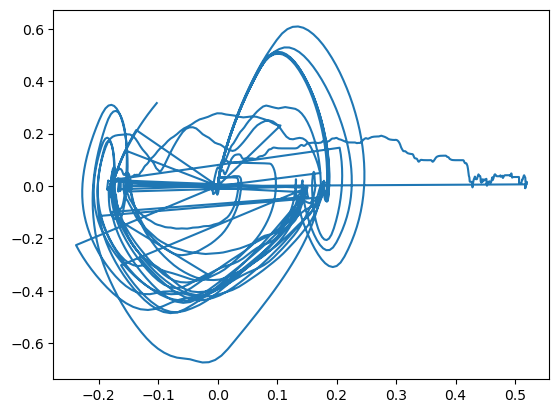

In [19]:
H_uy_noised, H_future_noised = get_datasets_hankel_matrix(io_data_list_4, lag, L)

# locs = np.array(np.vstack((H_uy_noised[:m,:], H_uy_noised[m*(lag+L):m*(lag+L)+p,:])).T)
locs = np.array(np.vstack((H_uy_noised[m*(lag+L):m*(lag+L)+p,:])).T)
plt.plot([loc[0] for loc in locs], [loc[1] for loc in locs])

1.1959863181749688


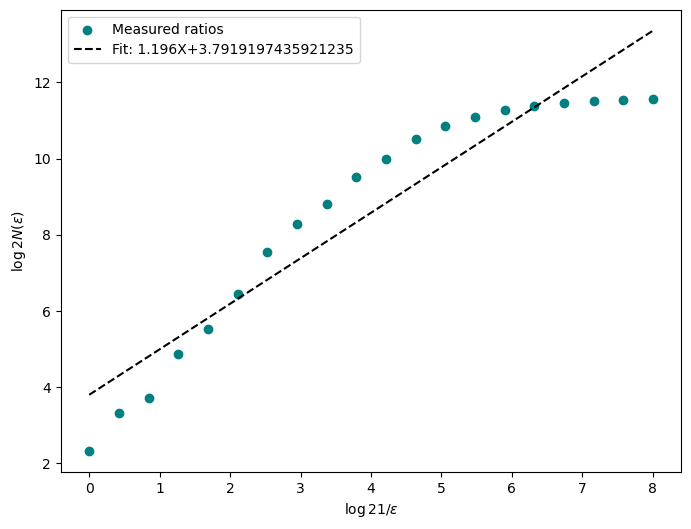

In [20]:
from tools.FractalDimension import fractal_dimension

a_min, a_max = -1.1, 5.5
delta_max = 0.4
v_x_min, v_x_max = 0.05, 3.2
v_y_min, v_y_max = -2.0, 2.0
mu_min, mu_max = -0.5*np.pi, 0.5*np.pi
track_width = 0.5

region_min = np.array([a_min, -delta_max, -track_width, mu_min, v_x_min, v_y_min])
region_max = np.array([a_max, delta_max, track_width, mu_max, v_x_max, v_y_max])

region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)

d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=0, min_box_size=-8, n_samples=20, plot=True)
print(d)
# print(log_N[-1]/log_inverse_size[-1])

1.3041261165660045


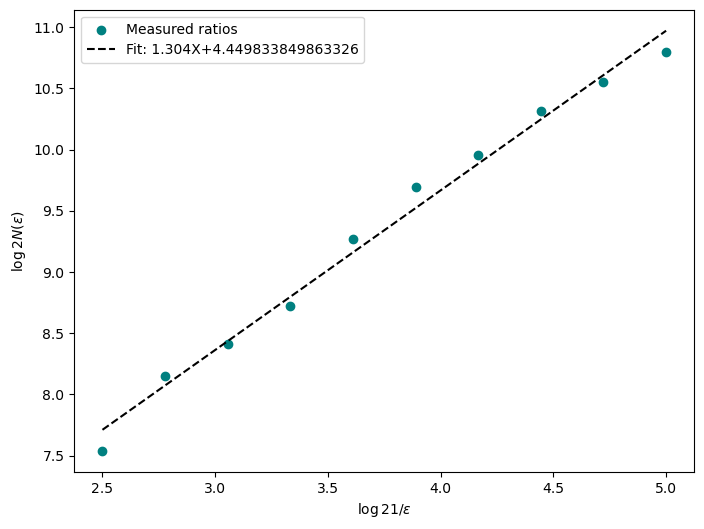

In [21]:
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-5, n_samples=10, plot=True)
print(d)